# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes.

In [34]:
options(repr.plot.width=8, repr.plot.height=3)

In [3]:
library(rstan)
options(mc.cores = parallel::detectCores() - 1)
rstan_options(auto_write = TRUE)

In [161]:
library(readr)
library(magrittr)
library(dplyr)
library(ggplot2)
library(greta)
library(LaplacesDemon)


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



The goal of this project is to estimate the model:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right), \sigma^2\right) \\
\end{align}

Since the MRF is particularly hard to estimate, we make use of a simpler representation first.

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(0.5, 0.5) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right), \sigma^2\right) \\
\end{align}

Another way to make thie easier:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Log-Norm}(0, .1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
\alpha & \propto 1 \\
x_{vgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left(\alpha +  \beta_{vg} \right) \right) \\
\end{align}

In [79]:
file_path <- file.path('../', 'data_raw', 'read_counts-normalized.tsv')

In [96]:
suppressMessages(
    sirnas <- readr::read_tsv(file_path) %>%
    dplyr::filter(Gene != "Control")
)

In [97]:
genes <- unique(sirnas$Gene)
replicates <- seq(2)
viruses <- 1

In [98]:
sirnas <- sirnas %>% 
    dplyr::select(sgRNA, Gene, LSLCas9_134, LSLCas9_136) %>%
    dplyr::rename(r1 = LSLCas9_134, r2 = LSLCas9_136) %>%
    tidyr::gather("replicate", "counts", -sgRNA, -Gene) %>%
    dplyr::mutate(counts = floor(counts)) %>%
    dplyr::arrange(sgRNA, replicate)

In [99]:
head(sirnas)

sgRNA,Gene,replicate,counts
ACSM3_sg001,ACSM3,r1,8987
ACSM3_sg001,ACSM3,r2,9300
ACSM3_sg002,ACSM3,r1,15742
ACSM3_sg002,ACSM3,r2,15869
ACSM3_sg003,ACSM3,r1,17348
ACSM3_sg003,ACSM3,r2,17373


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


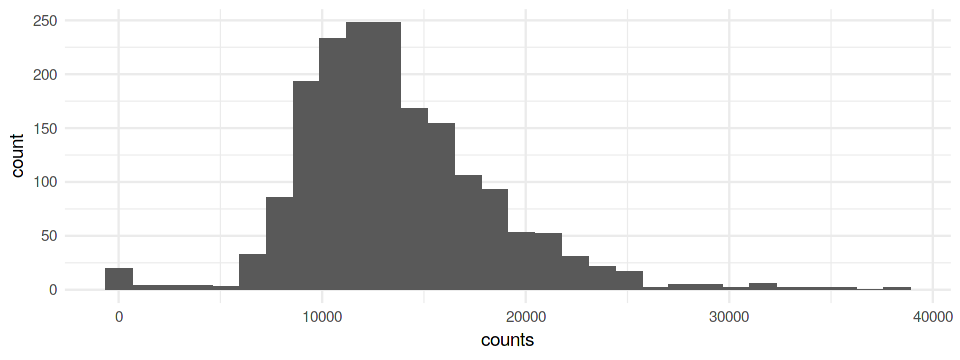

In [92]:
ggplot2::ggplot(sirnas, aes(counts)) +
    geom_histogram() +
    theme_minimal()

Since it is always _both_ replicates that have a low read count, it is safe to assume that these are no batch effects.

In [108]:
dplyr::filter(sirnas, counts < 5000) %>%
        dplyr::group_by(Gene) %>%
        dplyr::summarize(n=n())

Gene,n
B4GALT6,2
DKK4,2
EPHA4,2
EPN2,2
ESPL1,2
F11,2
FEZF2,2
FMO3,2
GNAI3,2
MNAT1,2


## Model 1

We start modelling with a simple hierarchical model to see if this suffices:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Log-Norm}(0, .1) \\
\alpha & \propto 1 \\
x_{vgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left(\alpha +  \beta_{vg} \right) \right) \\
\end{align}

## Simulated data

In [182]:
conditions <- paste0("C", 1:3)
genes   <- paste0("G", 1:3)
sirnas  <- paste0("S", 1:3)
replicates <- paste0("R", 1:3)

In [183]:
factor_table <- expand.grid(conditions, genes, sirnas, replicates) %>%
    magrittr::set_colnames(c("conditions", "genes", "sirnas", "replicates")) %>%
    dplyr::arrange(conditions, genes, sirnas, replicates)

In [184]:
dim(factor_table)

[1] 81  4

In [185]:
factor_table[1:10,]

conditions,genes,sirnas,replicates
C1,G1,S1,R1
C1,G1,S1,R2
C1,G1,S1,R3
C1,G1,S2,R1
C1,G1,S2,R2
C1,G1,S2,R3
C1,G1,S3,R1
C1,G1,S3,R2
C1,G1,S3,R3
C1,G2,S1,R1


In [186]:
tau_true <- rgamma(1, 1, 1)
gamma_true <- rnorm(length(genes), 0, tau)

In [211]:
beta_true <- MASS::mvrnorm(
    1, 
    rep(gamma_true, each=length(conditions)), 
    diag(tau, length(conditions) * length(genes)))
beta_true <- rep(beta_true, each = length(sirnas) * length(replicates))

In [214]:
l_true <- rlnorm(length(conditions) * length(genes) * length(sirnas), 0, 1)
l_true <- rep(l_true, each = length(replicates))

In [216]:
alpha_true <- runif(1, -10, 10)

In [217]:
factor_table$counts <- rpois(
    nrow(factor_table), 
    l_true * exp(alpha_true + beta_true)
)

In [ ]:
factor_

In [68]:
tau <- cauchy(0, 3, truncation = c(0, Inf))
gamma <- greta::normal(0, tau, dim = length(genes))
l <- greta::lognormal(0, 1, dim = length(genes) * length(viruses))
beta <- rep(gamma, each = length(viruses))

In [69]:
l <- rep(l, each = 2 * 10)
beta <- rep(beta, each = 2 * 10)

In [70]:
counts <- floor(sirnas$value)

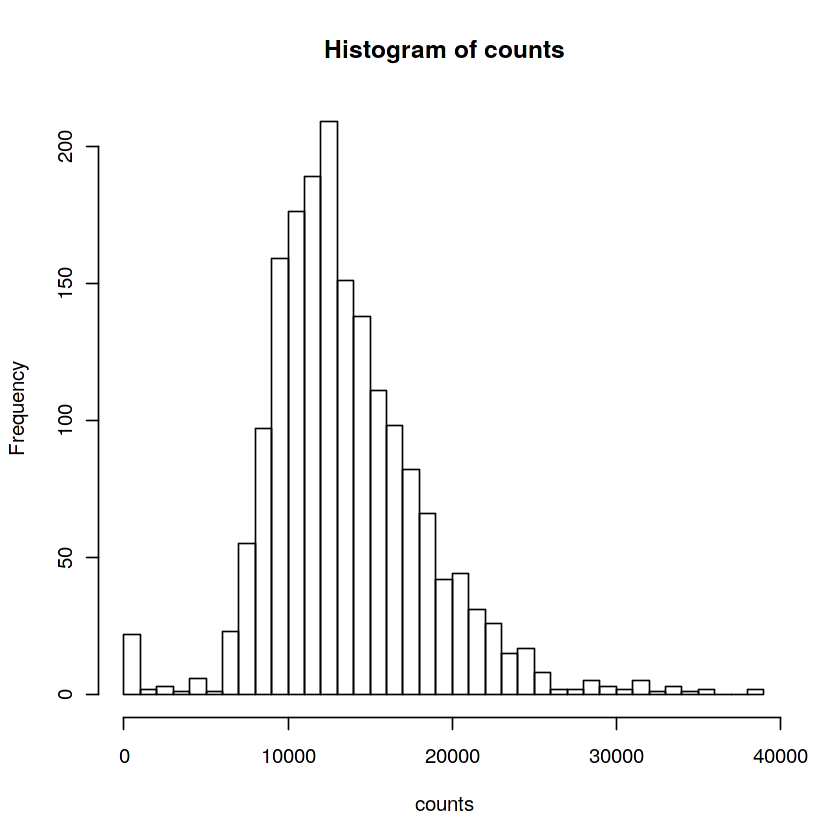

In [71]:
hist(counts, breaks = 50)

In [72]:
greta::distribution(counts) <- greta::poisson(l * exp(beta))

In [73]:
m <- greta::model(gamma)

In [74]:
samples <- greta::mcmc(m)


running 4 chains simultaneously on up to 4 cores

    warmup ====================================== 1000/1000 | eta:  0s | <1% bad
  sampling ====================================== 1000/1000 | eta:  0s          


In [77]:
coda::effectiveSize(samples)

gamma[1,1]  gamma[2,1]  gamma[3,1]  gamma[4,1]  gamma[5,1]  gamma[6,1] 
  10.509839   15.540649   20.606496   13.809790   21.028137   13.541217 
 gamma[7,1]  gamma[8,1]  gamma[9,1] gamma[10,1] gamma[11,1] gamma[12,1] 
  17.101204   20.409970   14.738786    9.247604   11.080528   12.041202 
gamma[13,1] gamma[14,1] gamma[15,1] gamma[16,1] gamma[17,1] gamma[18,1] 
  12.035630   11.565300   13.794284    9.895207   11.983252   12.910106 
gamma[19,1] gamma[20,1] gamma[21,1] gamma[22,1] gamma[23,1] gamma[24,1] 
  16.896667   18.383294   16.789961   13.512948   10.257306   18.774242 
gamma[25,1] gamma[26,1] gamma[27,1] gamma[28,1] gamma[29,1] gamma[30,1] 
  20.799001   12.509634    8.944471   16.900120   12.274694   11.314104 
gamma[31,1] gamma[32,1] gamma[33,1] gamma[34,1] gamma[35,1] gamma[36,1] 
  17.842140   11.867074   13.916789   10.903397   13.591157   16.044606 
gamma[37,1] gamma[38,1] gamma[39,1] gamma[40,1] gamma[41,1] gamma[42,1] 
  14.964447   14.372003   12.899495   16.383130   13.539322   18.626612 
gamma[43,1] gamma[44,1] gamma[45,1] gamma[46,1] gamma[47,1] gamma[48,1] 
   8.748937   19.832410   11.210126   14.616366   14.535437   17.628865 
gamma[49,1] gamma[50,1] gamma[51,1] gamma[52,1] gamma[53,1] gamma[54,1] 
  15.436236   14.947429   10.900563   22.240741   18.682556   10.137609 
gamma[55,1] gamma[56,1] gamma[57,1] gamma[58,1] gamma[59,1] gamma[60,1] 
   5.999061   10.654173   12.618180   11.992423   16.497274   14.699411 
gamma[61,1] gamma[62,1] gamma[63,1] gamma[64,1] gamma[65,1] gamma[66,1] 
  11.539673    9.653814   15.241522   13.634871   15.397011   22.136739 
gamma[67,1] gamma[68,1] gamma[69,1] gamma[70,1] gamma[71,1] gamma[72,1] 
  10.499964   11.576402   11.555855   16.809756   19.979892   14.885051 
gamma[73,1] gamma[74,1] gamma[75,1] gamma[76,1] gamma[77,1] gamma[78,1] 
  11.131634   24.828399   16.489168   10.610281   22.649147   22.952217 
gamma[79,1] gamma[80,1] gamma[81,1] gamma[82,1] gamma[83,1] gamma[84,1] 
  14.417053   18.030200   18.006481    7.311673   14.822721   18.351198 
gamma[85,1] gamma[86,1] gamma[87,1] gamma[88,1] gamma[89,1] gamma[90,1] 
   9.599498   19.138775    9.845863   17.432101   16.610285   25.430235

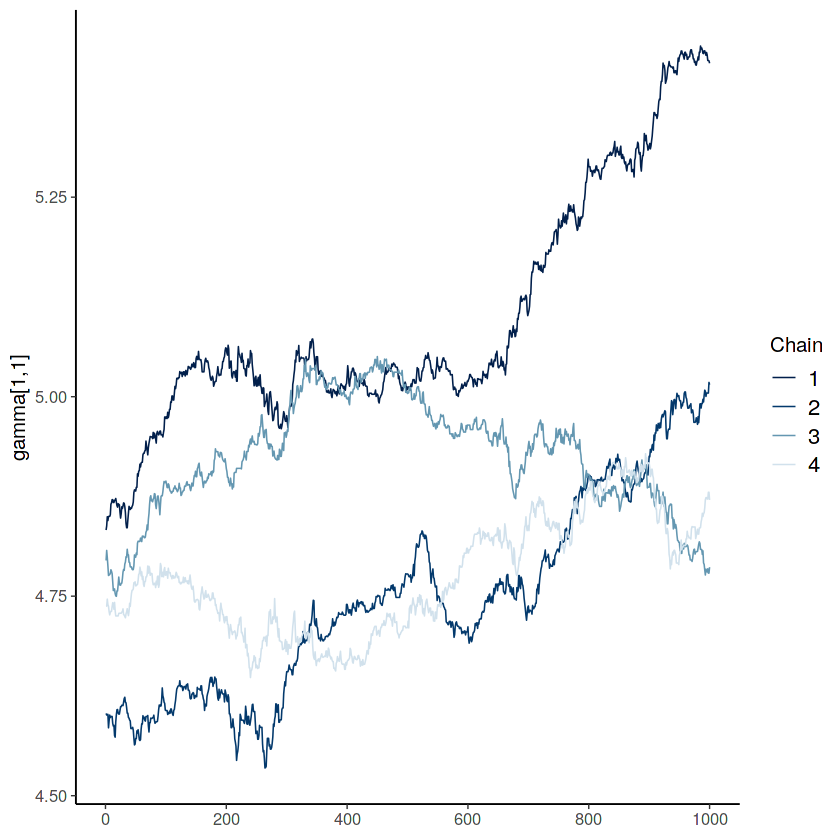

In [78]:
bayesplot::mcmc_trace(samples, pars = "gamma[1,1]")

In [95]:
s <- coda::gelman.diag(samples)

In [101]:
table(s$psrf[,1])


1.84156155032365 1.89481113491342 2.17045352493196 2.17460680804946 
               1                1                1                1 
2.23639671351334 2.30954406974991   2.638097461915 2.66954355217775 
               1                1                1                1 
2.67564464840803 2.67599205926657  2.8773214460867 3.08971541555882 
               1                1                1                1 
3.10215178006098 3.11919707956556 3.35140892567331 3.42298914858063 
               1                1                1                1 
3.42991919274125 3.54964452734447 3.65920294266368 3.78128422118451 
               1                1                1                1 
3.86739082326524 3.96310642197123  4.0400594831625 4.12618985951701 
               1                1                1                1 
 4.1649987639838 4.22951169242769 4.24576131881433 4.30437167265184 
               1                1                1                1 
4.32364169874033 4.33181554597987